# PI INF442-1 : Data Cleaning Household

In [1]:
# Importations

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from scipy import stats
from tqdm import tqdm

In [2]:
# Chargement des donnée des fichiers csv en un seul dataframe
# On utilise des fichiers modifiés auxquels on a rajouté les titres des colonnes
# On transforme tous les éléments numériques en flottants pour les manipuler plus tard

def load_household_data(filenames):
    data = pd.concat((pd.read_csv(f,dtype={'date':"string",'time':"string"},delimiter=";")
                      for f in filenames), ignore_index=True)
    cols = data.columns[data.dtypes.eq(object)]
    data[cols] = data[cols].apply(pd.to_numeric, errors='coerce')
    return data

filenames = ["household_power_consumption/titles/household_power_consumption_titles_20"+s+".csv"
             for s in ["07","08","09","10"]]

hh_data = load_household_data(filenames)
hh_data.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  import sys


,date,time,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
0,1/1/2007,00:00:00,2.580,0.136,241.97,10.6,0.0,0.0,0.0
1,1/1/2007,00:01:00,2.552,0.100,241.75,10.4,0.0,0.0,0.0
2,1/1/2007,00:02:00,2.550,0.100,241.64,10.4,0.0,0.0,0.0
3,1/1/2007,00:03:00,2.550,0.100,241.71,10.4,0.0,0.0,0.0
4,1/1/2007,00:04:00,2.554,0.100,241.98,10.4,0.0,0.0,0.0


In [3]:
# Informations sur les données avec le nombre de données manquantes

hh_data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2053263 entries, 0 to 2053262
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   date                   2053263 non-null  string 
 1   time                   2053263 non-null  string 
 2   global_active_power    2027288 non-null  float64
 3   global_reactive_power  2027288 non-null  float64
 4   voltage                2027288 non-null  float64
 5   global_intensity       2027288 non-null  float64
 6   sub_metering_1         2027288 non-null  float64
 7   sub_metering_2         2027288 non-null  float64
 8   sub_metering_3         2027288 non-null  float64
dtypes: float64(7), string(2)
memory usage: 141.0 MB


On observe qu'il n'y a pas de ligne où seulement quelques données manquent, il y a soit toutes les données soit aucune.

On choisit donc de supprimer directement toutes les lignes inutilisables.

In [4]:
# Suppression des données manquantes

hh_data.drop(hh_data.index[hh_data.isnull().any(axis=1)],0,inplace=True)
hh_data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2027288 entries, 0 to 2053262
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   date                   2027288 non-null  string 
 1   time                   2027288 non-null  string 
 2   global_active_power    2027288 non-null  float64
 3   global_reactive_power  2027288 non-null  float64
 4   voltage                2027288 non-null  float64
 5   global_intensity       2027288 non-null  float64
 6   sub_metering_1         2027288 non-null  float64
 7   sub_metering_2         2027288 non-null  float64
 8   sub_metering_3         2027288 non-null  float64
dtypes: float64(7), string(2)
memory usage: 154.7 MB


In [5]:
# Ajout d'une colonne de Z-score pour chaque métrique

cols = list(hh_data.columns)[2:]

for col in cols:
    col_zscore = col + '_zscore'
    hh_data[col_zscore] = abs((hh_data[col] - hh_data[col].mean())/hh_data[col].std())

In [6]:
# Élimination des données comportant une métrique avec un Z-score supérieur à un seuil

threshold = 7

new_data = hh_data.copy()
new_data.head()

for col in cols:
    col_zscore = col + '_zscore'
    new_data = new_data.drop(new_data.index[new_data[col_zscore] >= threshold],0,inplace=False)

print(f"Pourcentage d'outliers : {(1 - len(list(new_data.index))/len(list(hh_data.index)))*100:.3}%.")

Pourcentage d'outliers : 0.332%.


On observe qu'avec threshold de $5$ on détecte comme outliers environ $5\%$ des données, ce qui est trop important. Avec un trehshold 6 la quantité d'outliers passe à $1,5\%$ du jeu de données, et dès que le threshold est supérieur à 7 elle passe à environ $0.3\%$ et ne varie plus significativement.

On considère donc que les vrais outliers sont ceux qui sont éliminés par ce threshold. Cependant pour réaliser un choix plus rigoureux, on peut tracer le graphe du pourcentage d'outliers détectés en fonction du threshold.

100%|██████████| 50/50 [03:19<00:00,  4.00s/it]


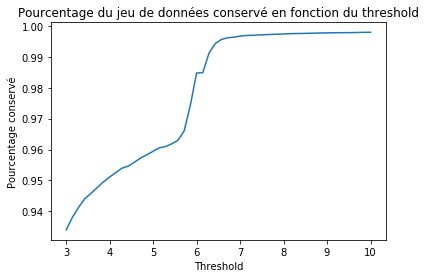

In [7]:
# Graphe des pourcentages d'outliers en fonction du threshold

nbrPts = 50
nbrInit = len(list(hh_data.index))
nbrData = [0]*nbrPts
thresholds = np.linspace(3,10,nbrPts)

for i in tqdm(range(nbrPts)):
    new_data = hh_data.copy()
    for col in cols:
        col_zscore = col + '_zscore'
        new_data.drop(new_data.index[new_data[col_zscore] >= thresholds[i]],0,inplace=True)
    nbrData[i] = len(list(new_data.index))
    
ratio = np.array(nbrData)/nbrInit
plt.plot(thresholds,ratio)
plt.xlabel("Threshold")
plt.ylabel("Pourcentage conservé")
plt.title("Pourcentage du jeu de données conservé en fonction du threshold")
plt.show()

Pour des données normalement distribuées, un threshold de $3$ donne environ $0.3\%$ d'outliers. Nous sommes très loin de cette valeur avec un pourcentage d'outliers plus de $20$ fois supérieur. Cela s'explique d'abord par le fait que nous travaillons en dimension $7$ et que nous avons choisi de supprimer toutes les données pour lesquelles au moins une des métriques pouvait être considérée comme un outlier. Cela augmente fortement le nombre d'outliers détectés.

Mais même en supposant que les outliers de chaque métrique sont distincts, le pourcentage détecté avec un threshold de $3$ ne devrait pas être plus de $7$ fois supérieur à $0.3\%$ (puisqu'il y a $7$ métriques). Il y a donc une raison autre que le hasard dans la présence d'outliers, qui est probablement dûe à des fluctuations des métriques très importantes sur des petites parties de la journée.

Il y a toutefois des "vrais" outliers dans le jeu de données. On observe ainsi un fort changement dans la courbe qui se produit aux environs d'une valeur de threshold de $6.5$. Après cette valeur, le nombre d'outliers stagne, et correspond probablement au nombre de "vrais" outliers. C'est donc cette valeur du threshold que l'on choisit pour éliminer les outliers.

In [8]:
# Élimination des outliers avec le threshold choisi

nbrInit = len(list(hh_data.index))
threshold = 6.5

for col in cols:
    col_zscore = col + '_zscore'
    hh_data.drop(hh_data.index[abs(hh_data[col_zscore]) >= threshold],0,inplace=True)
    
print(f"Pourcentage d'outliers : {(1 - len(list(hh_data.index))/nbrInit)*100:.3}%.")

Pourcentage d'outliers : 0.559%.


In [9]:
# Suppression des colonnes de Z-score plus utiles et vérification

hh_data.drop(hh_data.columns[9:],1,inplace=True)
print(f"Nombre d'entrées conservées : {len(list(hh_data.index))}.")
hh_data.head()

Nombre d'entrées conservées : 2015965.


,date,time,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
0,1/1/2007,00:00:00,2.580,0.136,241.97,10.6,0.0,0.0,0.0
1,1/1/2007,00:01:00,2.552,0.100,241.75,10.4,0.0,0.0,0.0
2,1/1/2007,00:02:00,2.550,0.100,241.64,10.4,0.0,0.0,0.0
3,1/1/2007,00:03:00,2.550,0.100,241.71,10.4,0.0,0.0,0.0
4,1/1/2007,00:04:00,2.554,0.100,241.98,10.4,0.0,0.0,0.0


En cumulant la suppression des données manquantes et la suppression des outliers, nous avons éliminé $1.8\%$ des données.

On a désormais un jeu de données "nettoyé". Il reste à effectuer un pre-processing avant de pouvoir appliquer les algorithmes classiques. Une première étape est la normalisation des données afin de donner un poids équivalent à chaque caractéristique. Ici certaines données ont des échelles très éloignées (de l'ordre de $10^{-1}$ à $10^2$), il parait donc justifié de normaliser. Pour des algorithmes supposant une distribution gaussienne, il pourra être intéressant d'effectuer plutôt une standardisation.

In [10]:
# Exportation du dataframe en fichier csv

hh_data.to_csv(f"preprocessed_household_threshold_{threshold}.csv", index = False)

In [11]:
# Normalisation des données pour donner le même poids aux features

hh_data_normalized = hh_data.copy()
hh_data_normalized[cols] = hh_data[cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
hh_data_normalized.head()

,date,time,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
0,1/1/2007,00:00:00,0.323765,0.159251,0.606462,0.315152,0.0,0.0,0.0
1,1/1/2007,00:01:00,0.320145,0.117096,0.599354,0.309091,0.0,0.0,0.0
2,1/1/2007,00:02:00,0.319886,0.117096,0.595800,0.309091,0.0,0.0,0.0
3,1/1/2007,00:03:00,0.319886,0.117096,0.598061,0.309091,0.0,0.0,0.0
4,1/1/2007,00:04:00,0.320403,0.117096,0.606785,0.309091,0.0,0.0,0.0


In [12]:
# Exportation du dataframe en fichier csv

hh_data_normalized.to_csv(f"preprocessed_household_normalized.csv", index = False)

In [13]:
rows = [i for i in range(1,len(hh_data))]

def moyenne_jour(dataframe):
    day_data = pd.DataFrame(columns=['date','time','global_active_power','globale_reactive_power','voltage', 'global_intensity','sub_metering_1','sub_metering_2', 'sub_metering_3'])
    ligne_temp = [dataframe.iloc[0,i] for i in range(9)]
    day_count = 1
    for r in tqdm(rows):
        if (dataframe.iloc[r,0] == ligne_temp[0]):
            day_count += 1
            for c in range(2,9):
                ligne_temp[c] += dataframe.iloc[r,c]
        else :
            for c in range(2,9):
                ligne_temp[c] = ligne_temp[c] / day_count
            add_data = pd.DataFrame([ligne_temp], columns=['date','time','global_active_power','globale_reactive_power','voltage', 'global_intensity','sub_metering_1','sub_metering_2', 'sub_metering_3'])
            day_data = day_data.append(add_data)
            ligne_temp= [dataframe.iloc[r,i] for i in range(9)]
            day_count = 1
            
    for c in range(2,9):
        ligne_temp[c] = ligne_temp[c] / day_count
    add_data = pd.DataFrame([ligne_temp], columns=['date','time','global_active_power','globale_reactive_power','voltage', 'global_intensity','sub_metering_1','sub_metering_2', 'sub_metering_3'])
    day_data = day_data.append(add_data)
    
    return day_data

day_data_normalized = moyenne_jour(hh_data_normalized)
day_data_normalized.head()

100%|██████████| 2015964/2015964 [02:55<00:00, 11496.59it/s]


,date,time,global_active_power,globale_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
0,1/1/2007,00:00:00,0.237009,0.120484,0.546978,0.233847,0.000000,0.006433,0.131720
0,2/1/2007,00:00:00,0.103568,0.153005,0.606081,0.105873,0.000000,0.006300,0.146183
0,3/1/2007,00:00:00,0.081226,0.159973,0.657741,0.085274,0.000000,0.006287,0.106743
0,4/1/2007,00:00:00,0.268662,0.161109,0.537339,0.267130,0.018337,0.086599,0.235512
0,5/1/2007,00:00:00,0.233809,0.140803,0.558829,0.232883,0.025119,0.006926,0.170296


In [14]:
# Exportation du dataframe en fichier csv

day_data_normalized.to_csv(f"preprocessed_household_norm_day.csv", index = False)

In [15]:
rows = [i for i in range(1,len(hh_data))]

def moyenne_heure(dataframe):
    hour_data = pd.DataFrame(columns=['date','time','global_active_power','globale_reactive_power','voltage', 'global_intensity','sub_metering_1','sub_metering_2', 'sub_metering_3'])
    ligne_temp = [dataframe.iloc[0,i] for i in range(9)]
    hour_count = 1
    for r in tqdm(rows):
        if (dataframe.iloc[r,1][0:2] == ligne_temp[1][0:2]):
            hour_count += 1
            for c in range(2,9):
                ligne_temp[c] += dataframe.iloc[r,c]
        else :
            for c in range(2,9):
                ligne_temp[c] = ligne_temp[c] / hour_count
            add_data = pd.DataFrame([ligne_temp], columns=['date','time','global_active_power','globale_reactive_power','voltage', 'global_intensity','sub_metering_1','sub_metering_2', 'sub_metering_3'])
            hour_data = hour_data.append(add_data)
            ligne_temp= [dataframe.iloc[r,i] for i in range(9)]
            hour_count = 1
            
    for c in range(2,9):
        ligne_temp[c] = ligne_temp[c] / hour_count
    add_data = pd.DataFrame([ligne_temp], columns=['date','time','global_active_power','globale_reactive_power','voltage', 'global_intensity','sub_metering_1','sub_metering_2', 'sub_metering_3'])
    hour_data = hour_data.append(add_data)
    
    return hour_data

hour_data_normalized = moyenne_heure(hh_data_normalized)
hour_data_normalized.head()

100%|██████████| 2015964/2015964 [03:59<00:00, 8423.64it/s]


,date,time,global_active_power,globale_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
0,1/1/2007,00:00:00,0.319968,0.132084,0.586796,0.313030,0.0,0.015351,0.0
0,1/1/2007,01:00:00,0.316447,0.083880,0.578239,0.310404,0.0,0.000000,0.0
0,1/1/2007,02:00:00,0.324067,0.124902,0.646209,0.313333,0.0,0.008772,0.0
0,1/1/2007,03:00:00,0.318809,0.105504,0.648325,0.309091,0.0,0.007018,0.0
0,1/1/2007,04:00:00,0.310284,0.103240,0.622170,0.300303,0.0,0.000000,0.0


In [16]:
# Exportation du dataframe en fichier csv

hour_data_normalized.to_csv(f"preprocessed_household_norm_hour.csv", index = False)

In [17]:
# Exportation en 24 dataframes divisés par heure

def séparation_heures(dataframe):
    hours_csv = []
    for i in tqdm(range(24)):
        data_temp = pd.DataFrame(columns=['date','time','global_active_power','globale_reactive_power','voltage', 'global_intensity','sub_metering_1','sub_metering_2', 'sub_metering_3'])
        for r in range(len(dataframe)):
            if (int(dataframe.iloc[r,1][0:2]) == i):
                add_data = pd.DataFrame([[dataframe.iloc[r,i] for i in range(9)]], columns=['date','time','global_active_power','globale_reactive_power','voltage', 'global_intensity','sub_metering_1','sub_metering_2', 'sub_metering_3'])
                data_temp = data_temp.append(add_data)
        hours_csv += [data_temp]
    return hours_csv

hours_csv = séparation_heures(hour_data_normalized)
for i in range(24):
    hours_csv[i].to_csv(f"preprocessed_household_norm_hour_{i}.csv", index = False)

100%|██████████| 24/24 [04:14<00:00, 10.61s/it]


In [18]:
# Exportation en 24 dataframes divisés par heure triés par active power

for i in range(24):
    hours_sorted = hours_csv[i].sort_values("global_active_power")
    hours_sorted.to_csv(f"preprocessed_household_sorted_hour_{i}.csv", index = False)

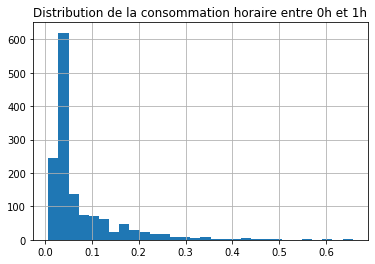

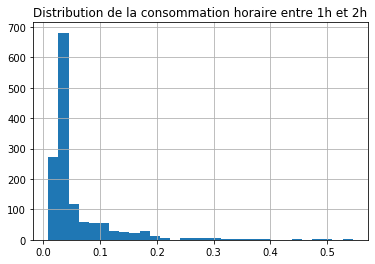

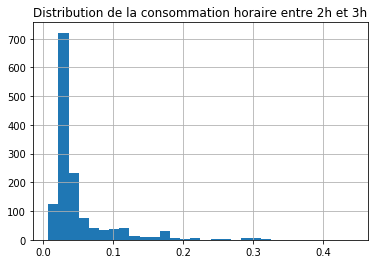

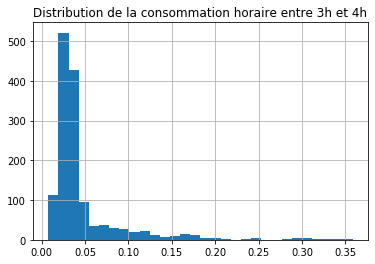

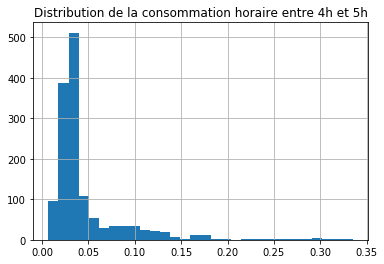

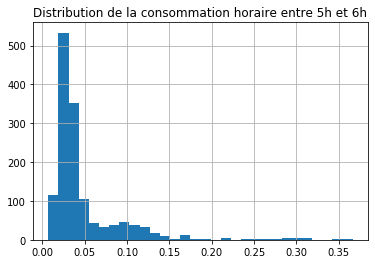

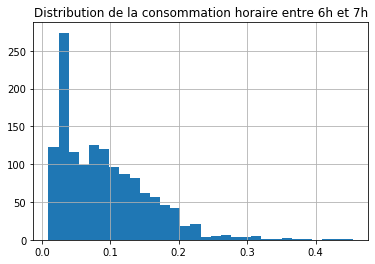

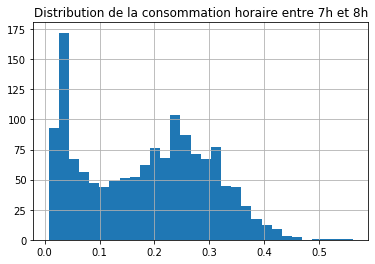

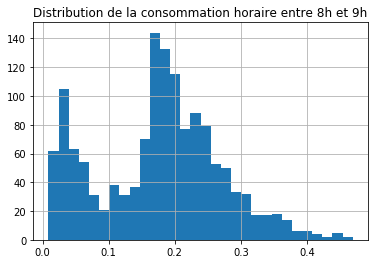

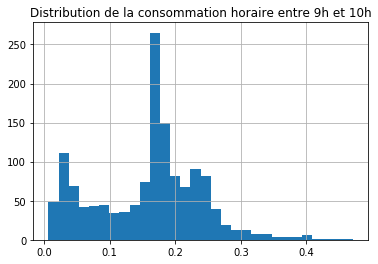

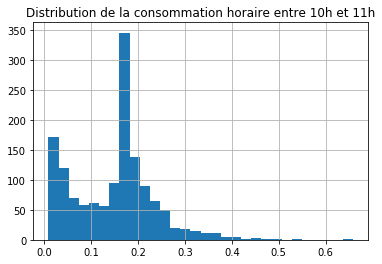

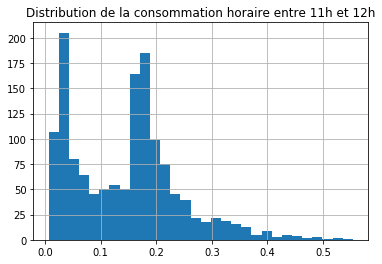

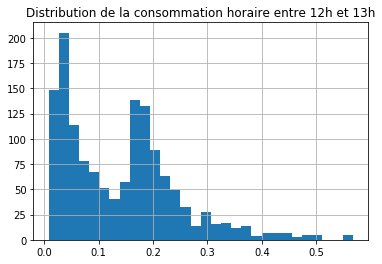

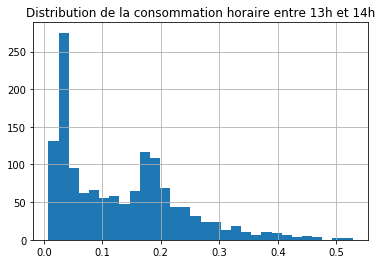

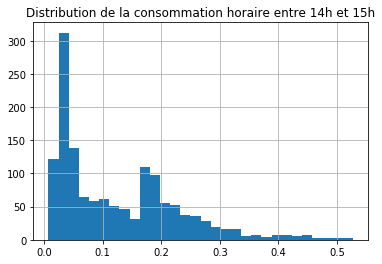

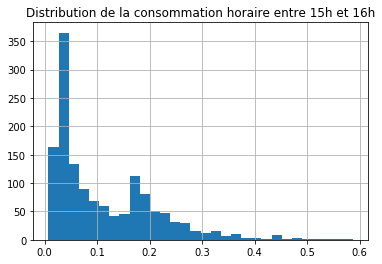

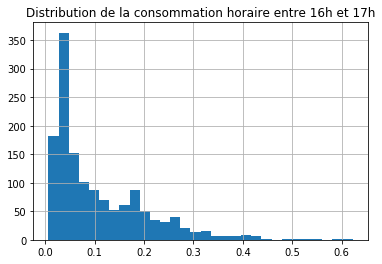

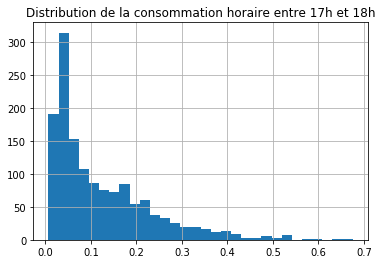

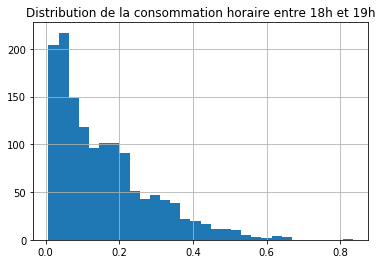

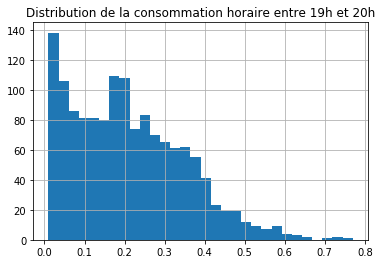

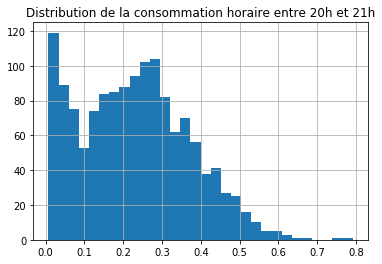

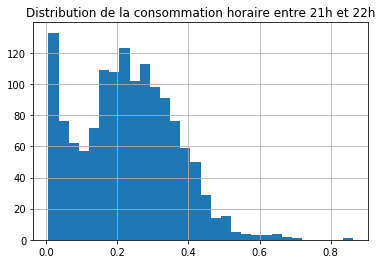

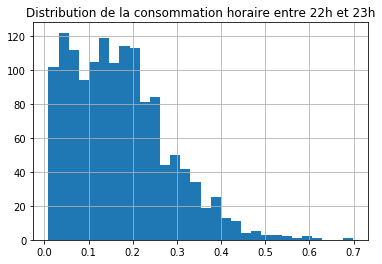

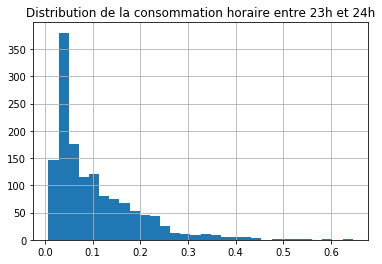

In [28]:
# Affichage des histogrammes des heures

for i in range(24):
    hist = hours_csv[i]["global_active_power"].hist(bins=30)
    plt.title(f"Distribution de la consommation horaire entre {i}h et {i+1}h")
    plt.show()